195
{'19858': 0, '24190': 1, '24191': 2, '24192': 3, '24193': 4, '24194': 5, '24195': 6, '24196': 7, '24305': 8, '24306': 9, '24307': 10, '24308': 11, '24309': 12, '24310': 13, '24311': 14, '24312': 15, '19857': 16}
Finished loading
1410


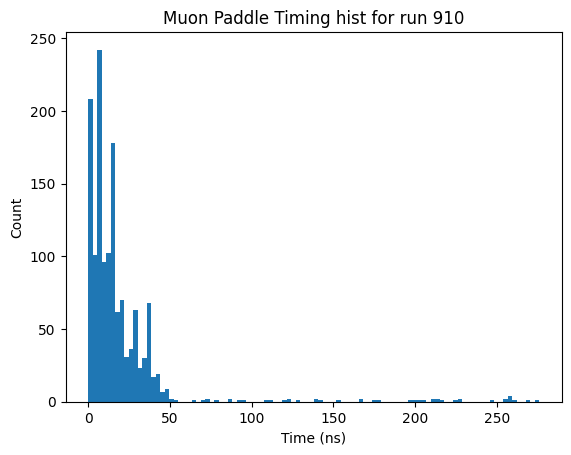

nan nan
11.443181818181818 23.827198913381558
10.891566265060241 17.287095297124786
nan nan
41.79387186629526 44.32736997006128
13.700272479564033 26.658555020557017


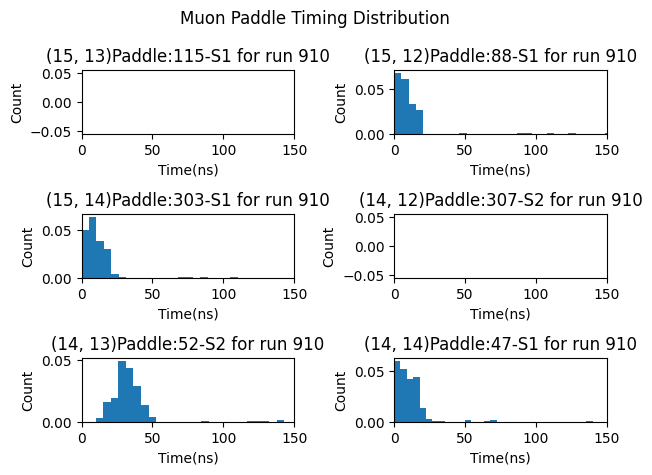

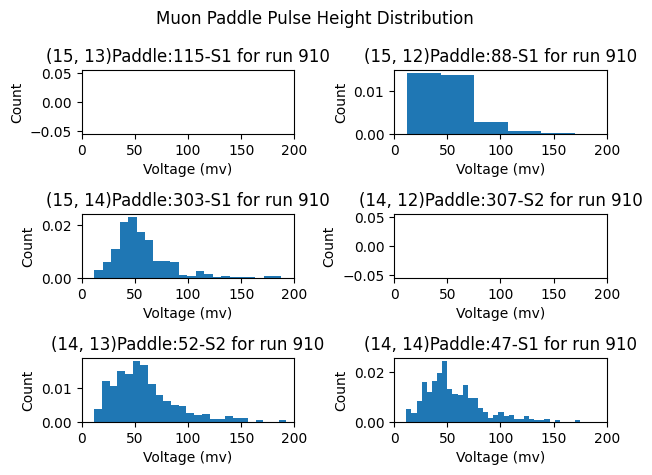

In [32]:
import ROOT
#import h5py
import h5pickle as h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import Waveform_Analysis.PMT_POSITIONS as pmtpos
import Waveform_Analysis.data_processing.settings as settings
import Waveform_Analysis.CABLE_DELAYS as cableDelays
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.mlab as mlab
import math
from multiprocessing import Pool

run_number = "910"
basefilename = "/mnt/data/eos/run"+ run_number +"/eos_data-diagnostic-run-" + run_number

#basefilename = "/mnt/data/eos/run312/eos_data-diagnostic-run-312"
#basefilename = "/mnt/data/eos/run357/eos_data-diagnostic-run-357"
#basefilename = "/mnt/data/eos/run909/eos_data-diagnostic-run-909"
#basefilename = "/mnt/data/eos/run910/eos_data-diagnostic-run-910"

filenames = []
runTitle = "run " + run_number

totalFiles = 9
h5Files = []
for i in range(0,totalFiles+1):
    filenames.append(basefilename + "."+ str(i) + ".h5")
    h5Files.append(h5py.File(basefilename + "."+ str(i) + ".h5", "r"))

# I hate this too don't worry
muonMapping ={
    "115-S1": (15, 13), # Middle Inner
    "88-S1": (15, 12), # Top inner
    "303-S1": (15, 14), # Top outer
    "307-S2": (14,12), # Bottom outer
    "52-S2": (14,13), # Bottom inner
    "47-S1": (14, 14) # Middle outer
}

board = 24312
board_id = 16
channel_id = 13

muonBoards = ["24311", "24312"]
muonChannels = [12,13,14]

voltage_offset = 1762 #Not needed started using the average voltage to find the baseline
trigger_threshhold = -10

voltage_offsets = { 
    "24311": 1762,
    "24312": 1760
}

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def countNhits(eventNumber, h5File) -> int: # Grabs amount of triggered pmts in a given event
    nhits = 0
    #with h5py.File(filename, "r") as h5File:
    for board in pmtpos.boards.values():
        boardId = list(pmtpos.boards.keys())[board]

        digit = h5File[str(boardId)]
        bits = digit.attrs['bits']
        nsamples = digit.attrs["samples"]
        if board == 16: # Last board is not used for pmts(?)
            continue
        
        for channel in range(0,15):
            if (board,channel) in muonMapping.values(): # Do not count the muon paddles
                continue
                
            
            channeldata = digit["ch%d" % channel]
            sampledata = channeldata["samples"]
            dynamic_range = channeldata.attrs["dynamic_range"]
            dv = dynamic_range/np.power(2,bits)
            dt = digit.attrs["ns_sample"]
            
            sample = sampledata[eventNumber]
            meanVoltage = np.mean(sample)
            #voltage = (sample*dv)-voltage_offsets[board]
            voltage = (sample-meanVoltage)*dv # Now using the meaning voltage to set the baseline
            minvoltage = voltage[np.argmin(voltage)]
            maxvoltage = voltage[np.argmax(voltage)]
        
            #print(minvoltage)
            #time = np.arange(0, nsamples*dt, dt)
            if minvoltage < trigger_threshhold:
                #plt.plot(time, voltage)
                #plt.show()
                nhits += 1
                    
    return nhits
    
print(countNhits(4,h5Files[0]))

print(pmtpos.boards)
print("Finished loading")

muonHits = {
    "115-S1": [],
    "88-S1": [],
    "303-S1": [],
    "307-S2": [],
    "52-S2": [],
    "47-S1": []
}

triggered_samples = []
pulse_heights_samples = []
times = []
trigger_threshhold = -10
time = None

for f in h5Files:
    
    for board in muonBoards:
        digit = f[str(board)]
        bits = digit.attrs['bits']
        nsamples = digit.attrs["samples"]
        for channelId in muonChannels:
            channel = digit["ch%d" % channelId]
            data = channel["samples"]
            dynamic_range = channel.attrs["dynamic_range"]
            dv = dynamic_range/np.power(2,bits)
            dt = digit.attrs["ns_sample"]

            time = np.arange(0, nsamples*dt, dt)

            i = 0 #Keeps track of what event a sample came from
            for sample in data:
                meanVoltage = np.mean(sample)
                #voltage = (sample*dv)-voltage_offsets[board]
                voltage = (sample-meanVoltage)*dv # Now using the meaning voltage to set the baseline
                minvoltage = voltage[np.argmin(voltage)]
                maxvoltage = voltage[np.argmax(voltage)]

                pulse_height = maxvoltage-minvoltage
            
                #print(minvoltage)
                if minvoltage < trigger_threshhold:

                    #nhits = countNhits(0, f)

                    muonHits[list(muonMapping.keys())[list(muonMapping.values()).index((pmtpos.boards[board],channelId))]].append((voltage,time[np.argmin(voltage)], i, f, pulse_height))
                    
                    triggered_samples.append(voltage)
                    times.append(time[np.argmin(voltage)])
                    # # print("test")
                    # plt.plot(time,(voltage))
            
                    # plt.xlabel("Time (ns)")
                    # plt.ylabel("Voltage (mV)")
                    # plt.ylim([-30,10])
                    # plt.show()

                i += 1
# print(len(times))
# plt.plot(time,triggered_samples[10])
# plt.plot(time, [trigger_threshhold]*(len(time)))
# plt.ylim([-30,10])
# #plt.xlim([0,250])
#plt.show()
print(len(times))
plt.hist(times, bins=100)
plt.title("Muon Paddle Timing hist for " + runTitle)
plt.xlabel("Time (ns)")
plt.ylabel("Count")
plt.show()

#print(muonHits["115-S1"][0])
# plt.plot(time, muonHits["115-S1"][0][0])
# plt.show()

muonTimingHist, muonTimingAxis = plt.subplots(3,2)

muonFigureMapping ={
    "115-S1": (0, 0), # Middle Inner
    "88-S1": (0, 1), # Top inner
    "303-S1": (1, 0), # Top outer
    "307-S2": (1,1), # Bottom outer
    "52-S2": (2,0), # Bottom inner
    "47-S1": (2, 1) # Middle outer
}
###
### PLOT TIMING HISTS
###

muonTimingHist.suptitle("Muon Paddle Timing Distribution")
for muonPaddle, samples in muonHits.items():
    muonTiming = []
    for sample in samples:
        #print(sample)
        muonTiming.append(sample[1])

    (mu, sigma) = norm.fit(muonTiming)
    print(mu, sigma)
    n, bins, patches = muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].hist(muonTiming,density=True,bins=50)

    y = norm.pdf(bins,mu,sigma)
    #l = muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].plot(bins,y,"r--",linewidth=2)
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_title(str(muonMapping[muonPaddle]) + "Paddle:"+ muonPaddle + " for " + runTitle)
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_xlabel("Time(ns)")
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_ylabel("Count")
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_xlim([0,150])

plt.tight_layout()
plt.show()
###
### PLOT PULSE HEIGHT HISTS
###

muonPulseHeightHist, muonPulseHeightAxis = plt.subplots(3,2)
muonPulseHeightHist.suptitle("Muon Paddle Pulse Height Distribution")
for muonPaddle, samples in muonHits.items():
    muonVoltage= []
    for sample in samples:
        #print(sample)
        muonVoltage.append(sample[4])

    #(mu, sigma) = norm.fit(muonTiming)
    #print(mu, sigma)
    n, bins, patches = muonPulseHeightAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].hist(muonVoltage,density=True, bins=50)

    y = norm.pdf(bins,mu,sigma)
    #l = muonPulseHeightAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].plot(bins,y,"r--",linewidth=2)
    muonPulseHeightAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_title(str(muonMapping[muonPaddle]) + "Paddle:"+ muonPaddle + " for " + runTitle)
    muonPulseHeightAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_xlabel("Voltage (mv)")
    muonPulseHeightAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_ylabel("Count")
    muonPulseHeightAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_xlim([0,200])

#plt.title("Pulse time distribution")
plt.tight_layout()
plt.show()

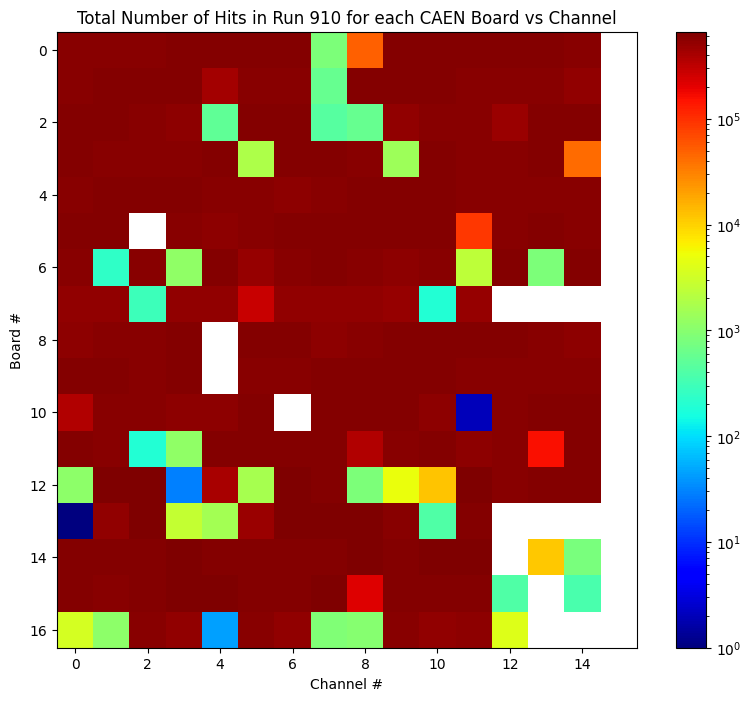

nMuonHits nTotalHits nMuonHits/nTotalHits
1275412.0 118209506.0 0.01078941993040729
nhits in B14C11-B15-C14
[[6.36878e+05 0.00000e+00 1.14960e+04 7.75000e+02]
 [6.25503e+05 4.06000e+02 0.00000e+00 3.54000e+02]]


In [33]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## SET THE RUN NUMBER!
#run_number = "909" #New Digitizer Configuration with 30 samples additional readout.
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10!
#run_number = "417" #12 hour run no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

#print(len(charge[0]))
#print(nhit[0])

PMTHits = np.zeros([17,16])
#print(PMTHits.shape)
for iEvt in range(0,len(event_number)):
    #print(len(board[aEvt]),len(channel[aEvt]), nhit[aEvt])
    for iHit in range(0,len(board[iEvt])):
        #print(board[iEvt][iHit])
        PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]=PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]+1

plt.figure(figsize=(10,8))
plt.imshow(PMTHits, cmap='jet',norm=colors.LogNorm())
plt.title("Total Number of Hits in Run "+run_number+" for each CAEN Board vs Channel")
plt.xlabel("Channel #")
plt.ylabel("Board #")
plt.colorbar()
plt.show()

nMuonHits = np.sum(PMTHits[14:16,11:15])
nTotalHits= np.sum(PMTHits)
print("nMuonHits nTotalHits nMuonHits/nTotalHits")
print(nMuonHits,nTotalHits,nMuonHits/nTotalHits)
print("nhits in B14C11-B15-C14")
print(PMTHits[14:16,11:15])

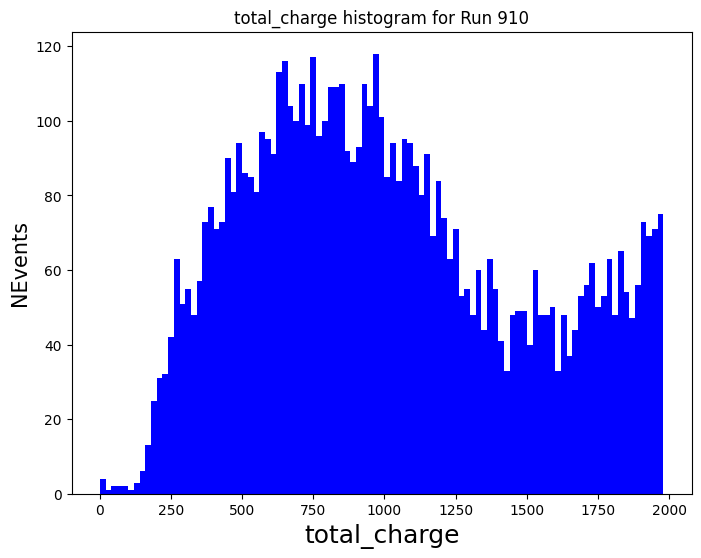

In [34]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
#run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
total_charge = rdf.AsNumpy(columns=["total_charge"])["total_charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nhit_lowDT = []
total_charge_lowDT =[]


for iEvt in range(0,len(event_number)):
    if(deltat[iEvt] < 10):
        nhit_lowDT.append(nhit[iEvt])
        total_charge_lowDT.append(total_charge[iEvt])


count, bin_edges = np.histogram(total_charge_lowDT, bins=np.arange(0,2000,20))
bin_centers =[]
for ie in range(1,len(bin_edges)):
    bin_centers.append((bin_edges[ie]+bin_edges[ie-1])/2)


plt.figure(figsize=(8,6))
plt.bar(bin_centers, count, color ='blue', width = 20, label="data")

plt.title("total_charge histogram for Run "+run_number)
plt.xlabel("total_charge",fontsize=18)
plt.ylabel("NEvents",fontsize=15)

plt.show()